In [1]:
from train import train_epochs
from gan_sn import Generator, Discriminator
# from utils.utils import *
from utils.exp1 import experiment_save_results, visualize_experiment_dataset, experiment_data
import utils.pytorch_utils as ptu

from utils.utils import savefig
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
from torch.optim.lr_scheduler import StepLR
from scipy import stats, integrate
import time
import pandas as pd

/Users/maximzubkov/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/maximzubkov/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
g = {}
c = {}

In [3]:
n_modes = 3
params = [(2, 0.4),(0, 0.55),(5, 0.25)]

In [4]:
delta = {}

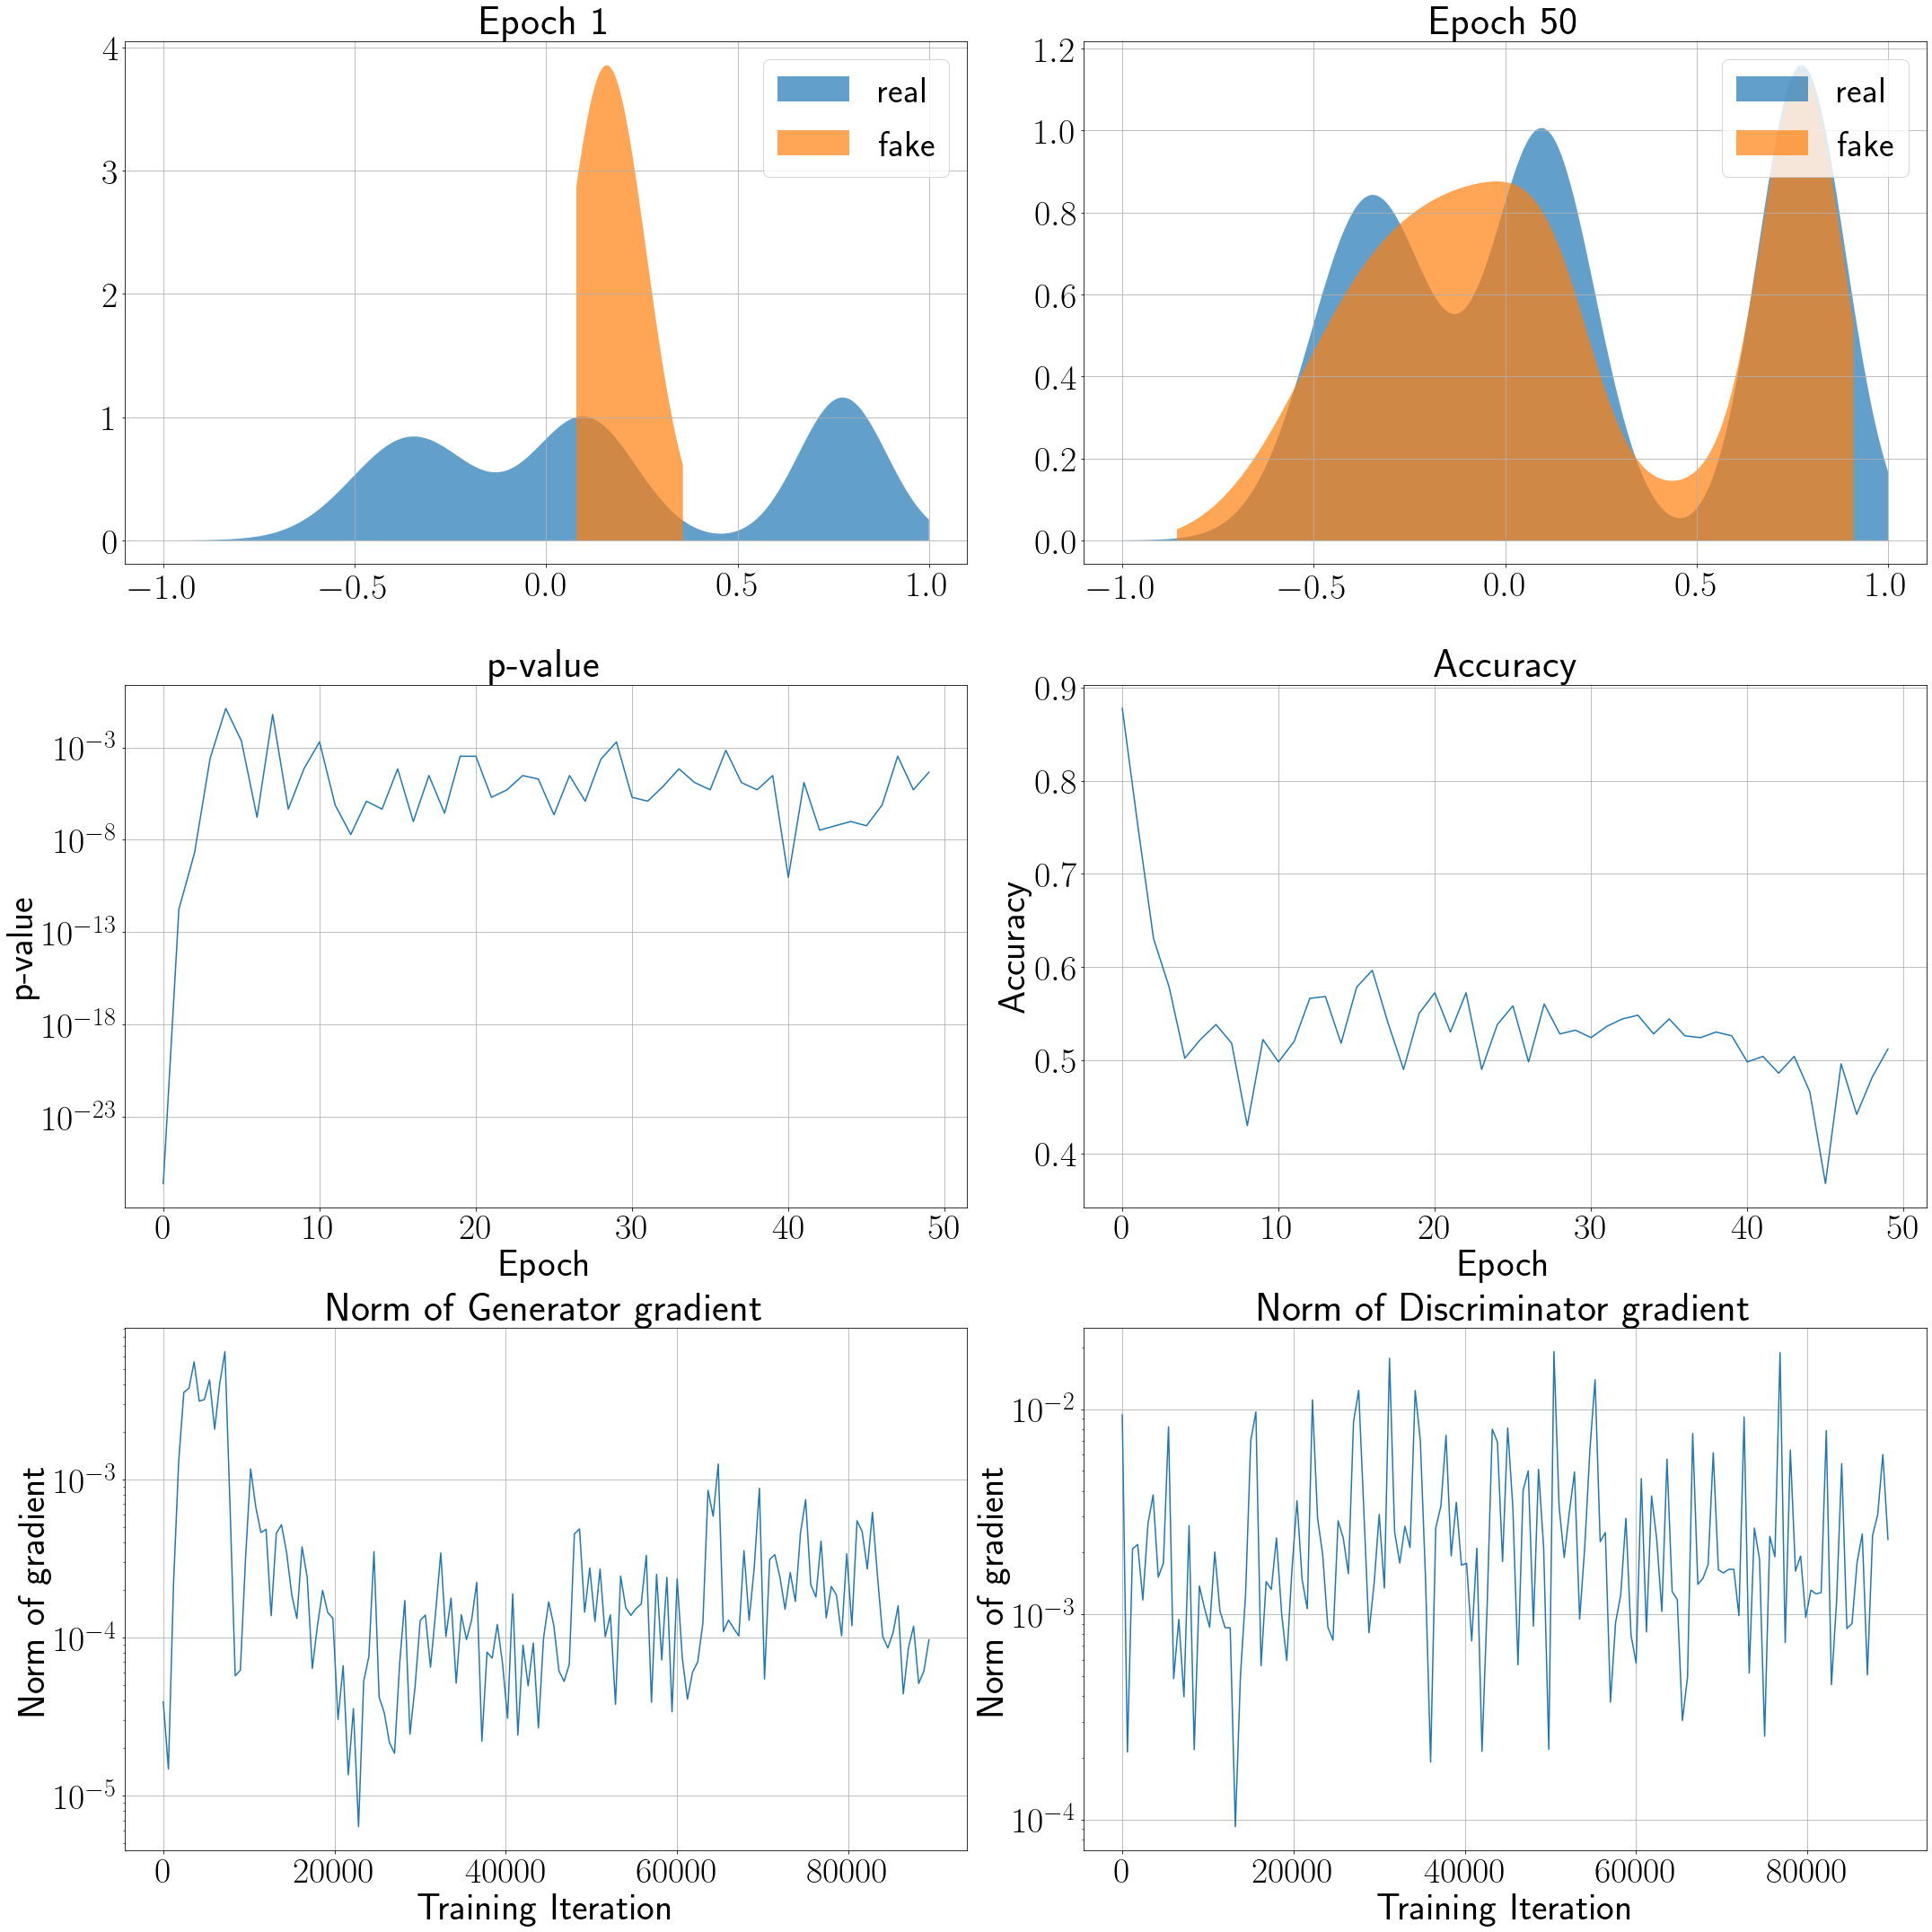

In [7]:
for n_cr in [2, 4, 6]:
    def exp1(train_data):
        loader_args = dict(batch_size=64, shuffle=True)
        train_loader = data.DataLoader(train_data, **loader_args)

        g[n_cr] = Generator(3, 3, 25, 1).to(ptu.device)
        c[n_cr] = Discriminator(1, 3, 25, 1).to(ptu.device)

        # wasserstein
        def g_loss(generator, critic, x):
            fake_data = generator.sample(x.shape[0])
            return - critic(fake_data).mean()

        def c_loss(generator, critic, x):
            fake_data = generator.sample(x.shape[0])
            return critic(fake_data).mean() - critic(x).mean()
        n_epochs = 50
        c_opt = optim.Adam(c[n_cr].parameters(), lr=9e-5, betas=(0, 0.9))
        g_opt = optim.Adam(g[n_cr].parameters(), lr=9e-5, betas=(0, 0.9))
        train_args = {
            "epochs": n_epochs, 
            "n_critic": n_cr, 
            "final_snapshot":True,
        }
        result = train_epochs(g[n_cr], c[n_cr], g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                              c_opt=c_opt, is_spiral=False, modes=n_modes, name=f"sn_ncr{n_cr}", param_modes=params) #, g_scheduler=g_scheduler, c_scheduler=c_scheduler)
        train_losses, samples_1, samples_final = result
        return g[n_cr], c[n_cr], train_losses, samples_1, samples_final

    start = time.time()
    g[n_cr], c[n_cr], train_losses, samples_1, samples_final = experiment_save_results('a', exp1, f"sn_ncr{n_cr}", 
                                                                           is_spiral=False,
                                                                           modes=n_modes,
                                                                           param_modes=params)
    end = time.time()
    delta[n_cr] = end-start
    np.save(f"results/sn_ncr{n_cr}/p", train_losses["pvals"])
    np.save(f"results/sn_ncr{n_cr}/c_grad", train_losses["c_grad"])
    np.save(f"results/sn_ncr{n_cr}/g_grad", train_losses["g_grad"])
    

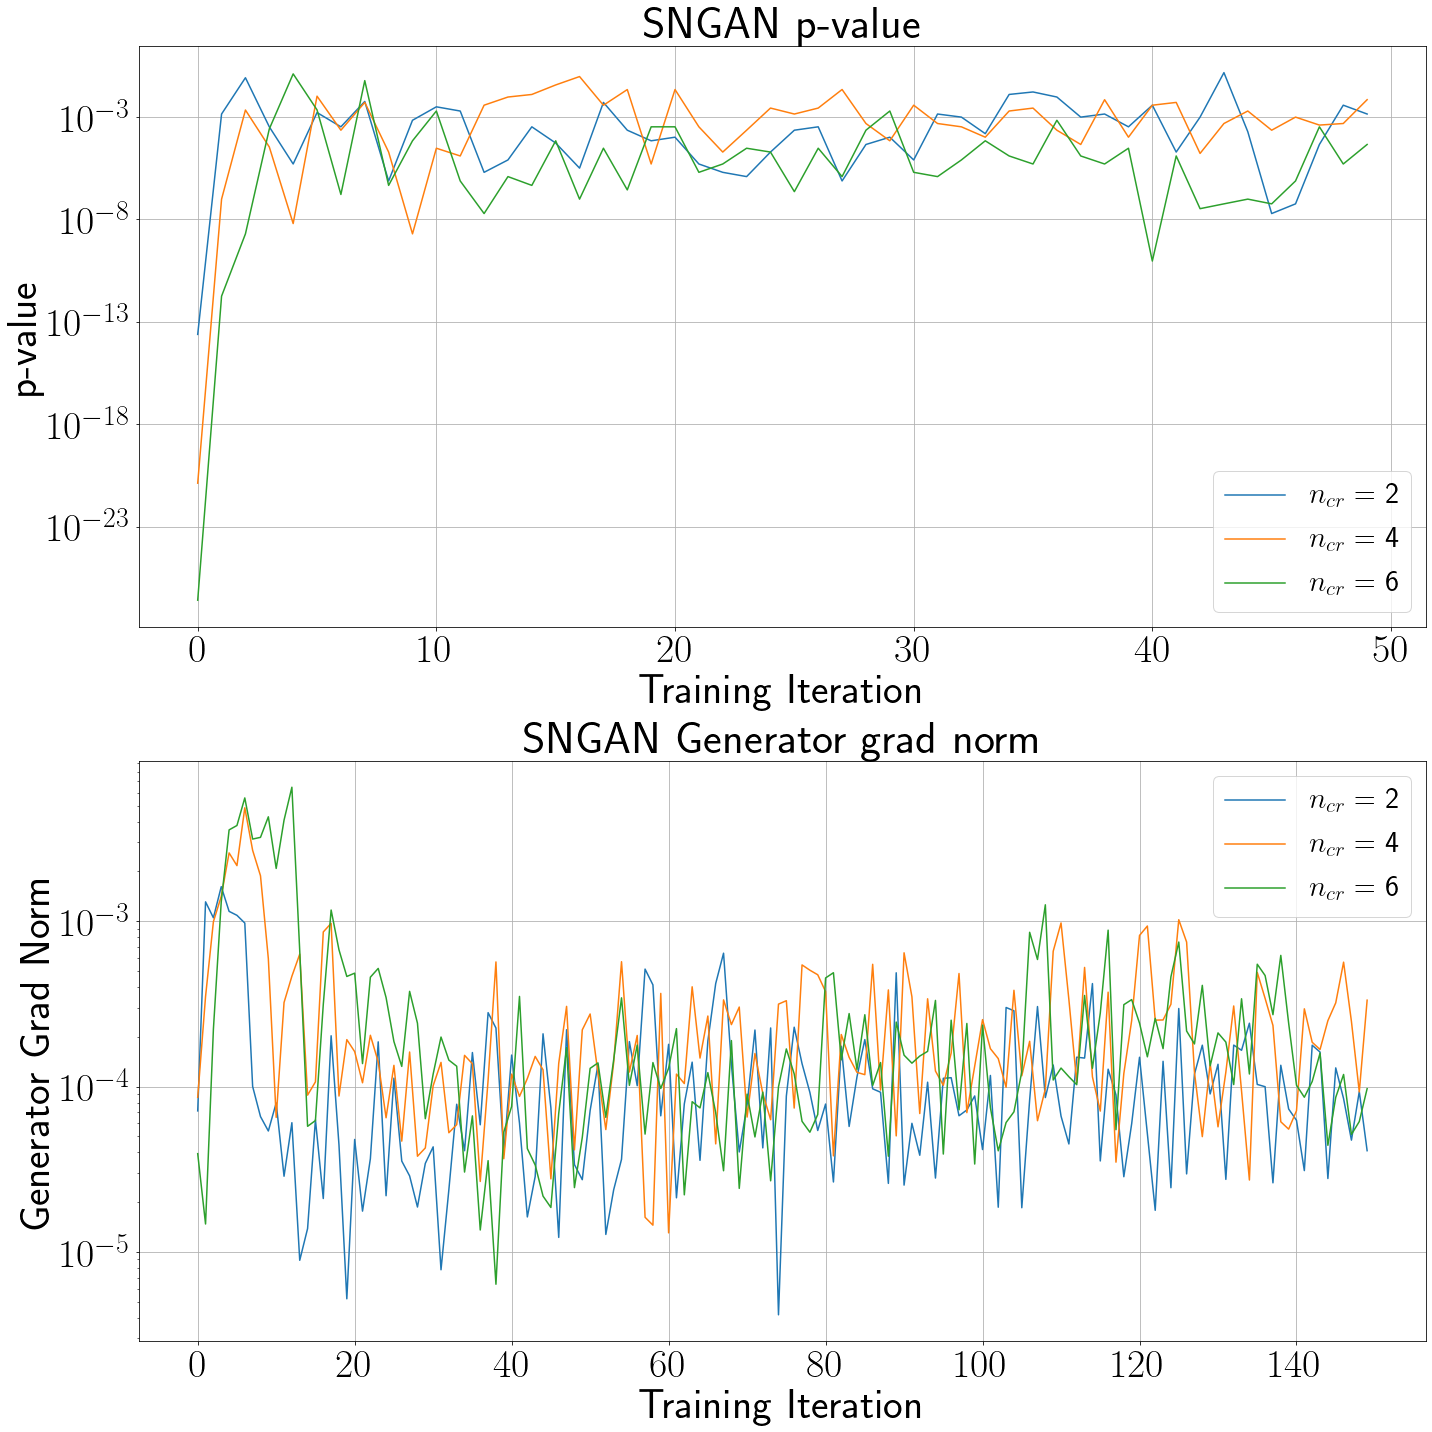

In [8]:
plt.figure(figsize=(20, 20))
ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(2, 1, 2)
ax1.set_title("SNGAN p-value", fontsize=45)
ax2.set_title("SNGAN Generator grad norm", fontsize=45)
for n_cr in [2, 4, 6]:
    ax1.semilogy(np.load(f"results/sn_ncr{n_cr}/p.npy"), label="$n_{cr}= $"+f" {n_cr}")
    ax1.set_xlabel('Training Iteration',fontsize=42)
    ax1.set_ylabel('p-value',fontsize=42)
    ax1.tick_params(axis="x", labelsize=40)
    ax1.tick_params(axis="y", labelsize=40)
    ax2.semilogy(np.load(f"results/sn_ncr{n_cr}/g_grad.npy"), label="$n_{cr}= $"+f" {n_cr}")
    ax2.set_xlabel('Training Iteration',fontsize=42)
    ax2.set_ylabel('Generator Grad Norm',fontsize=42)
    ax2.tick_params(axis="x", labelsize=40)
    ax2.tick_params(axis="y", labelsize=40)
ax1.grid()
ax1.legend(fontsize=30)
ax2.grid()
ax2.legend(fontsize=30)
    
savefig("results/compare_sn.pdf")

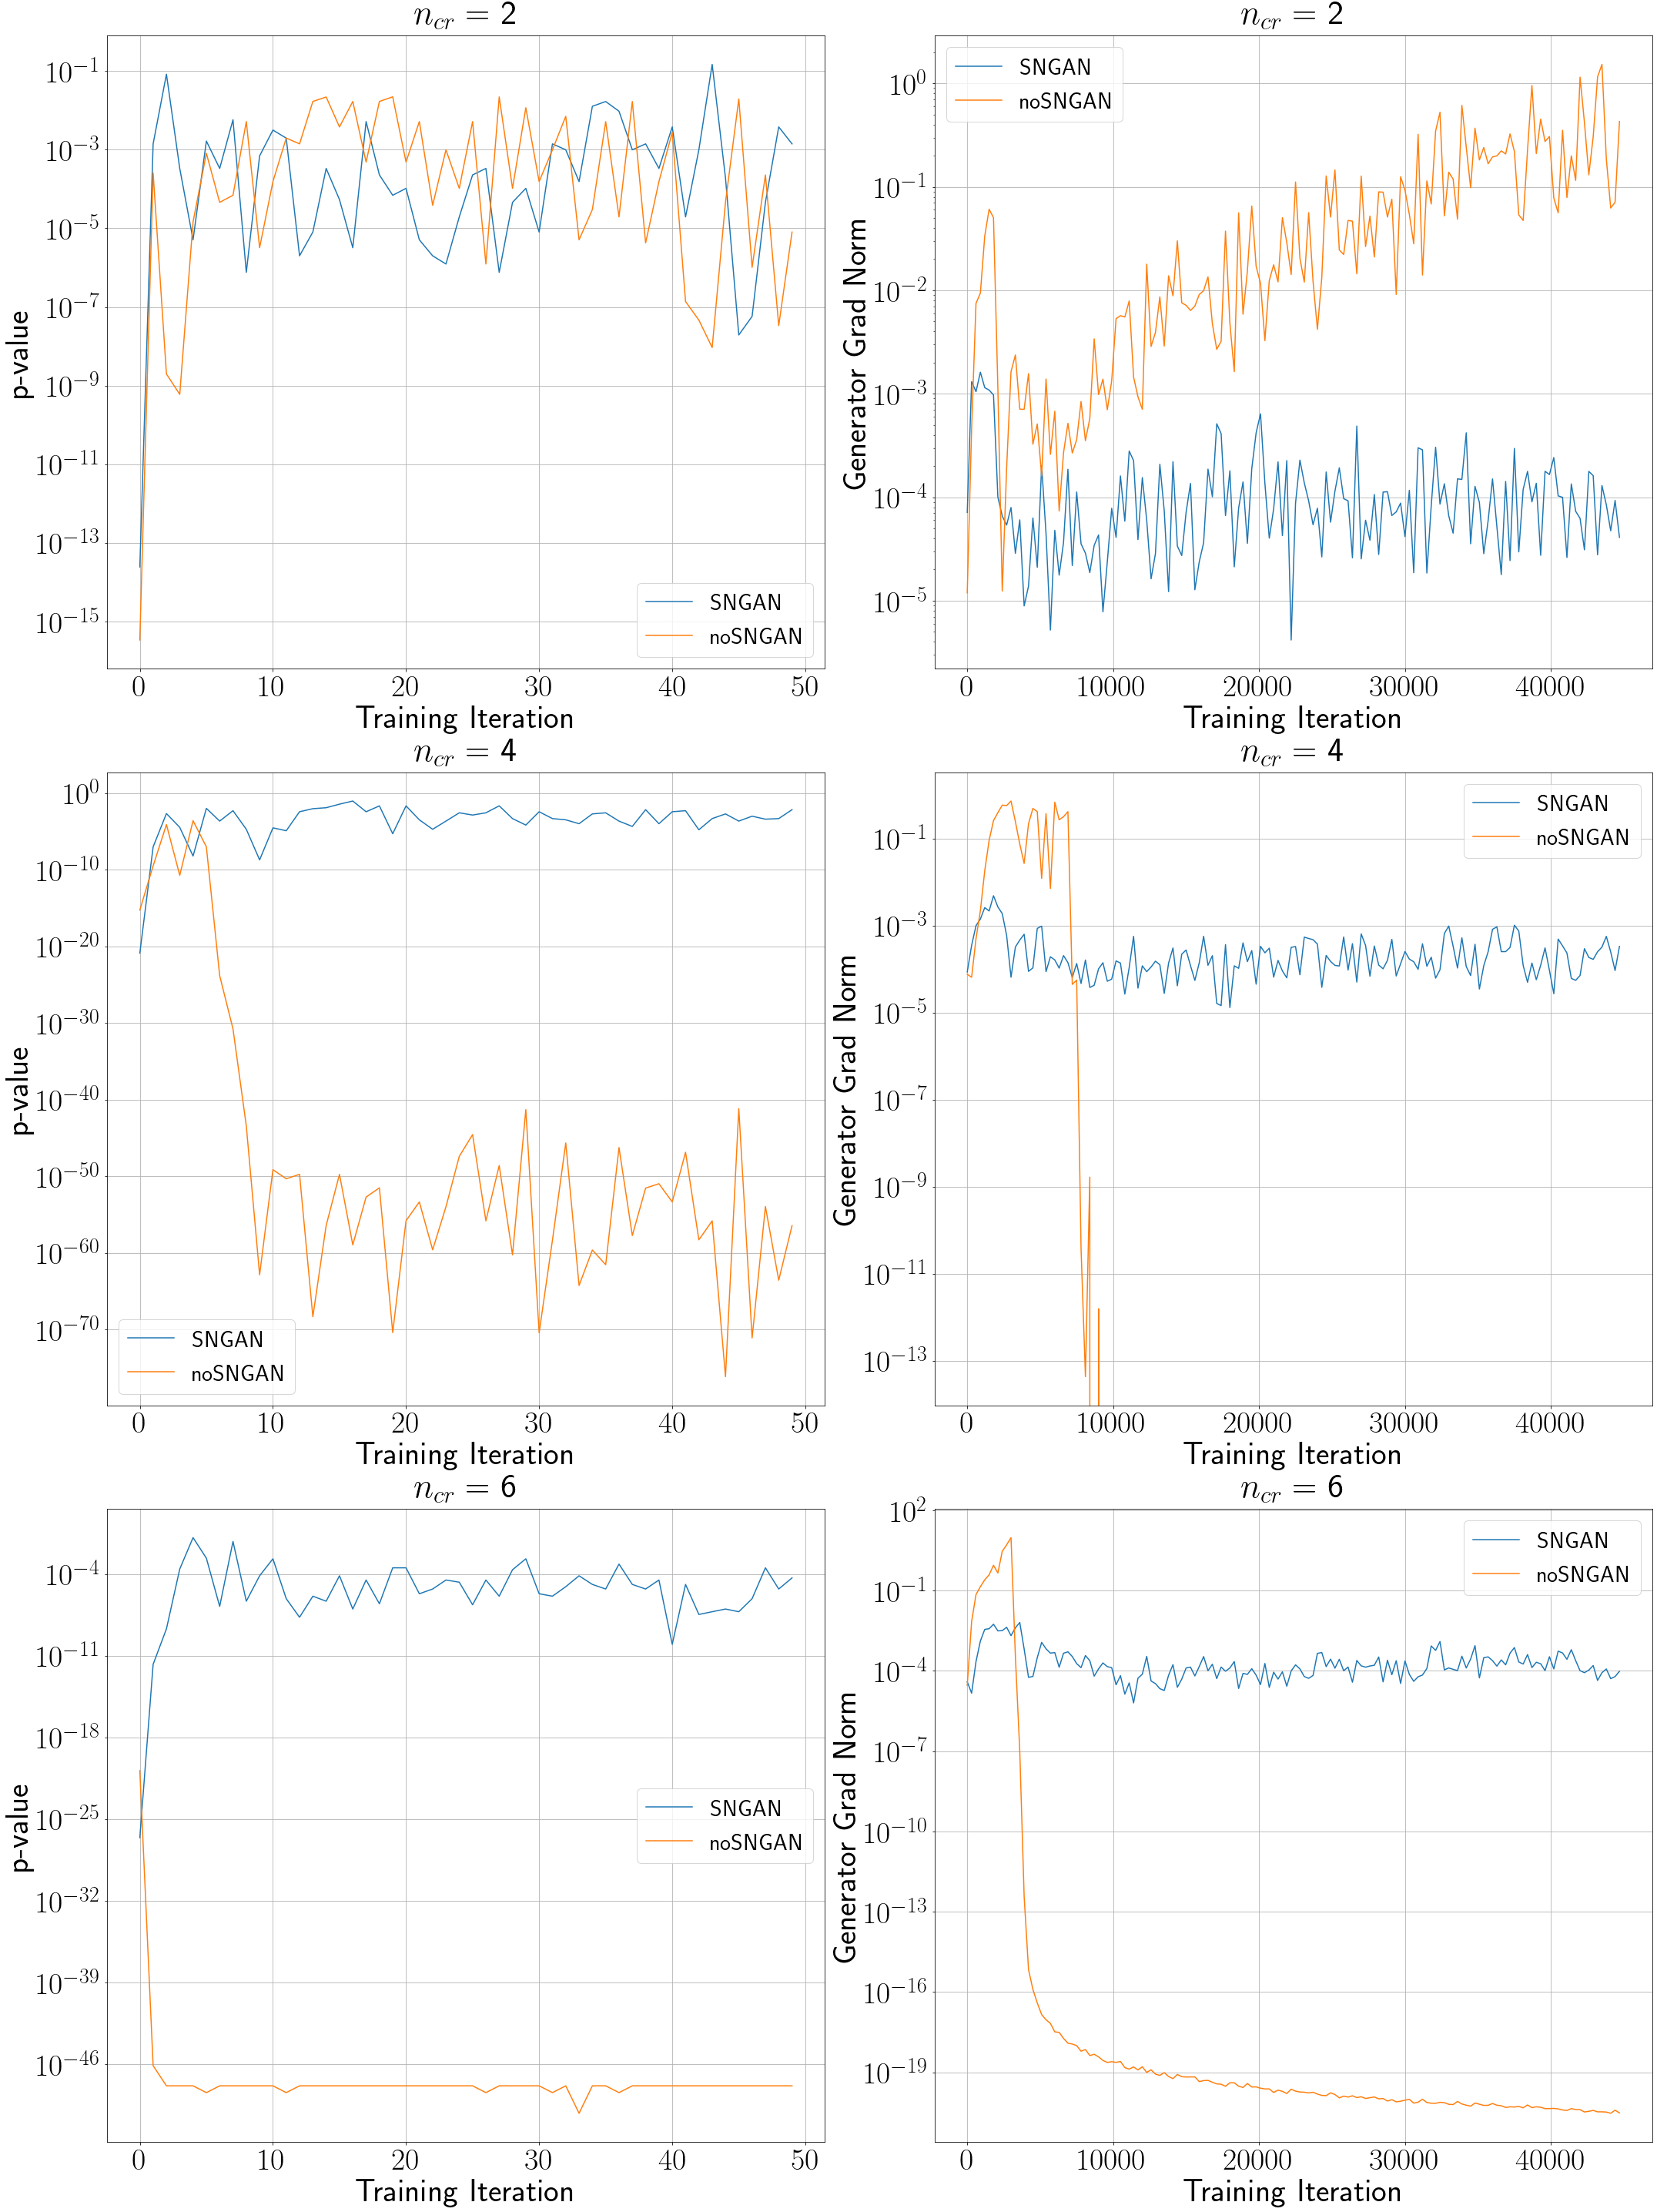

In [9]:
plt.figure(figsize=(30, 40))
ax = {}
ax[2] = {}
ax[4] = {}
ax[6] = {}
ax[2][0]=plt.subplot(3, 2, 1)
ax[2][1]=plt.subplot(3, 2, 2)
ax[4][0]=plt.subplot(3, 2, 3)
ax[4][1]=plt.subplot(3, 2, 4)
ax[6][0]=plt.subplot(3, 2, 5)
ax[6][1]=plt.subplot(3, 2, 6)
for n_cr in [2, 4, 6]:
    ax[n_cr][0].set_title("$n_{cr}= $"+f" {n_cr}", fontsize=45)
    ax[n_cr][0].semilogy(np.load(f"results/sn_ncr{n_cr}/p.npy"), label=f"SNGAN")
    ax[n_cr][0].semilogy(np.load(f"results/ncr{n_cr}/p.npy"), label=f"noSNGAN")
    ax[n_cr][0].set_xlabel('Training Iteration',fontsize=42)
    ax[n_cr][0].set_ylabel('p-value',fontsize=42)
    ax[n_cr][0].tick_params(axis="x", labelsize=40)
    ax[n_cr][0].tick_params(axis="y", labelsize=40)
    ax[n_cr][0].grid()
    ax[n_cr][0].legend(fontsize=30)
    x = [300 * x for x in range(len(np.load(f"results/sn_ncr{n_cr}/g_grad.npy")))]
    ax[n_cr][1].set_title("$n_{cr}= $"+f" {n_cr}", fontsize=45)
    ax[n_cr][1].semilogy(x, np.load(f"results/sn_ncr{n_cr}/g_grad.npy"), label=f"SNGAN")
    x = [300 * x  for x in range(len(np.load(f"results/ncr{n_cr}/g_grad.npy")))]
    ax[n_cr][1].semilogy(x, np.load(f"results/ncr{n_cr}/g_grad.npy"), label=f"noSNGAN")
    ax[n_cr][1].set_xlabel('Training Iteration',fontsize=42)
    ax[n_cr][1].set_ylabel('Generator Grad Norm',fontsize=42)
    ax[n_cr][1].tick_params(axis="x", labelsize=40)
    ax[n_cr][1].tick_params(axis="y", labelsize=40)
    ax[n_cr][1].grid()
    ax[n_cr][1].legend(fontsize=30)
    
savefig("results/compare.pdf")

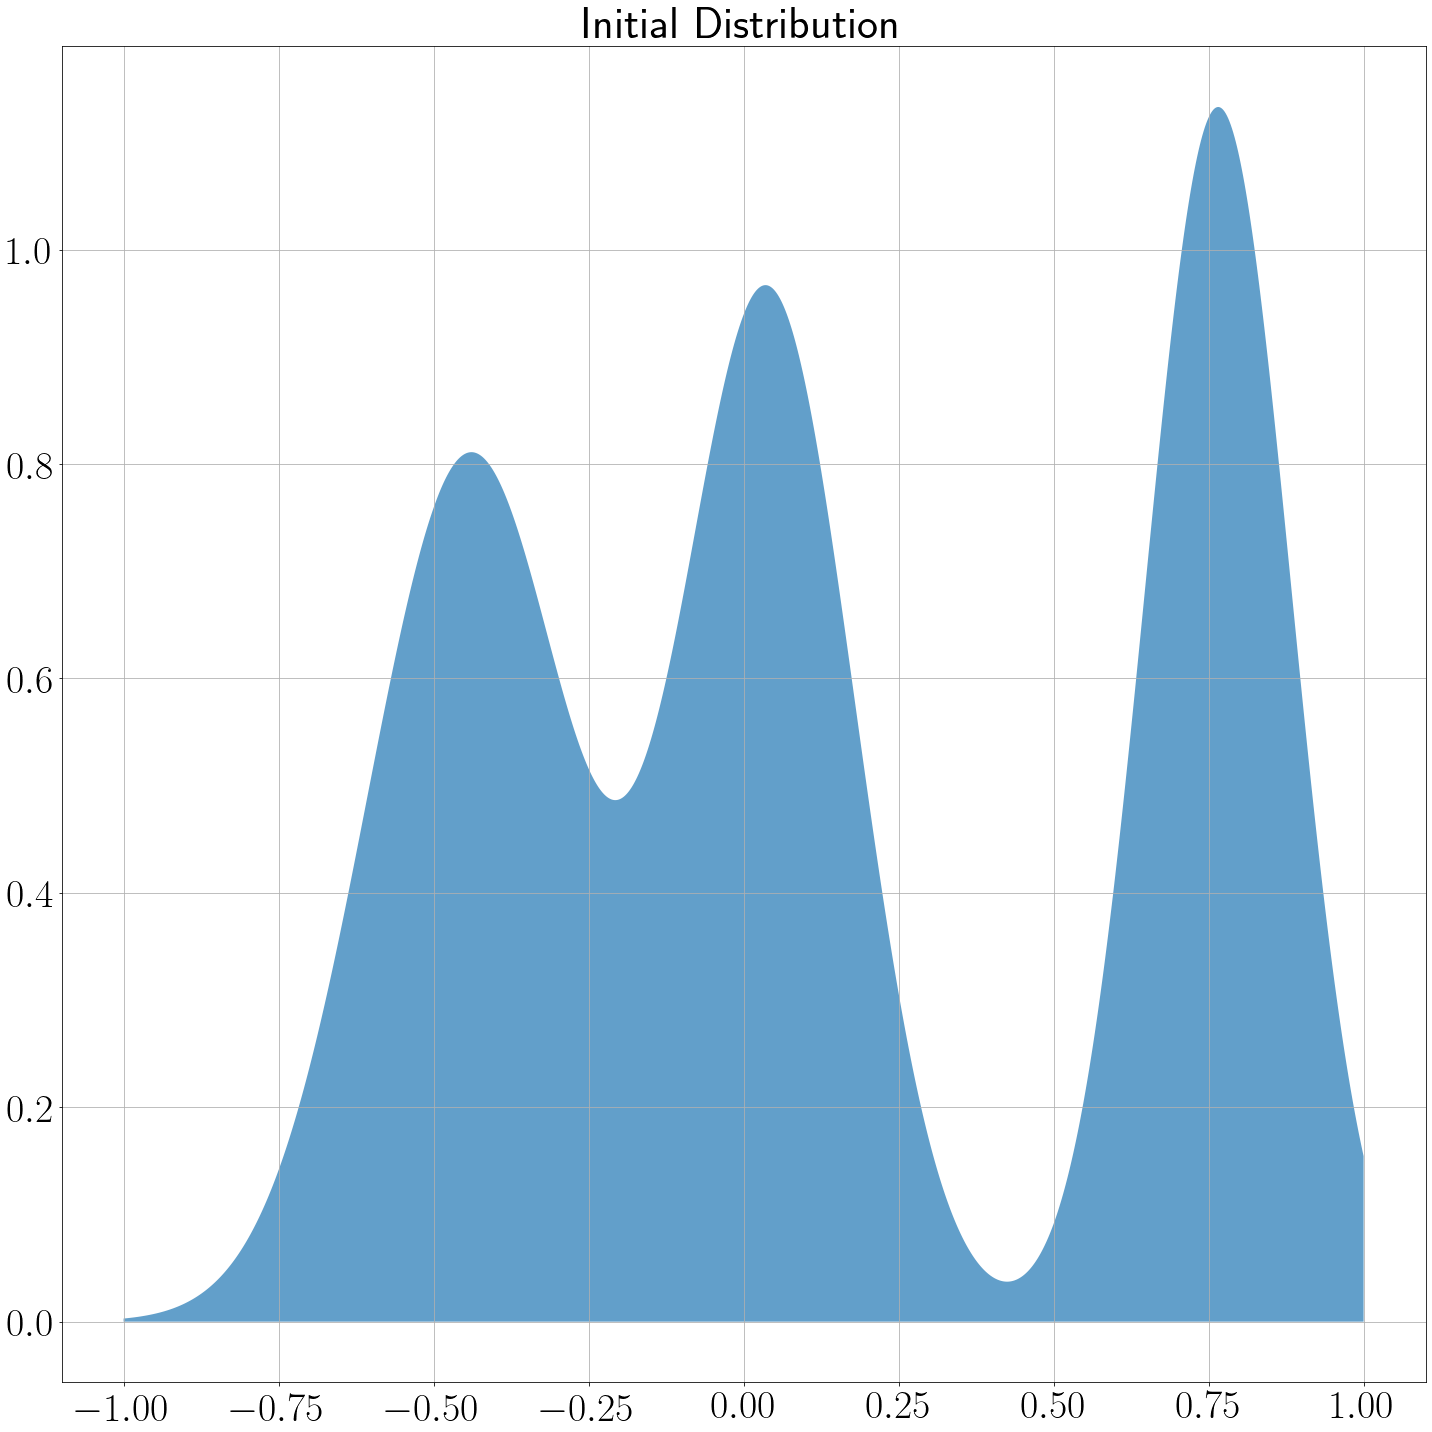

In [5]:
visualize_experiment_dataset(is_spiral=False, modes=n_modes, param_modes=params)

In [47]:
delta

{2: 234.82655310630798, 4: 209.77042508125305, 6: 205.16864585876465}

> Формула для спирали $r(\theta) = a+b\theta$

In [ ]:
a = experiment_data(n=1, is_spiral=True, n_modes=3, params=params)

In [ ]:
visualize_experiment_dataset(is_spiral=True)

In [ ]:
def exp2(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    
    g = Generator(10, 7, 50, 2).to(ptu.device)
    c = Discriminator(2, 4, 30, 1).to(ptu.device)


    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()
    
    def c_loss(generator, critic, x):
        batch_size = x.shape[0]
        fake_data = generator.sample(batch_size)
        return critic(fake_data).mean() - critic(x).mean() #- 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 500

    c_opt = optim.Adam(c.parameters(), lr=9e-5, betas=(0, 0.9))
    g_opt = optim.Adam(g.parameters(), lr=9e-5, betas=(0.5, 0.9))
#     c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=250, gamma=0.8)
#     g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=200, gamma=0.9)
    train_args = {
        "epochs": n_epochs, 
        "n_critic": 5, 
        "final_snapshot":True
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=True, name="spiralsncr2")
    train_losses, samples_1, samples_final = result
    return g, c, train_losses['c_losses'], samples_1, samples_final

In [ ]:
start = time.time()
g, c, *_ = experiment_save_results('a', exp2, 'spiral', is_spiral=True)
end = time.time()
delta.append(end-start)